## Install dependencies

In [1]:


# For Notebook:
# %pip install ollama
# %pip install openai
# %pip install anthropic
# %pip install transformers
# %pip install tiktoken
# %pip install python-dotenv
# %pip install colorama



# For packages: 
# %pip install scikit-learn
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install iterative-stratification
# %pip install langchain

#For WebUI testing:
# %pip install open-webui



## Prepare data

### Prompt template

### Example selector

## Split data

In [2]:

import sys
sys.path.append('../../')  # Add the path to the my_packages module
from my_packages.data_processing.split_dataset import kfold_few_shot, multi_shot_split_ensure_valtest_coverage, split_on_shots_nodes, read_dataset_to_json
from my_packages.data_processing.get_labels_data import used_libraries_from_dataset, used_libraries_to_string
from my_packages.analysis.analyze_datasets import analyze_library_distribution, analyze_instance_distribution, analyze_visual_node_types_distribution

import numpy as np
from sklearn.model_selection import train_test_split

main_dataset_folder = '../../data/mbpp_transformed_code_examples/sanitized-MBPP-midio.json'

# 1) Load the data
dataset = read_dataset_to_json(main_dataset_folder)

# 2) Convert to a numpy array of objects
data = np.array(dataset, dtype=object)

prompts = [item['prompts'][0] for item in dataset]   # e.g., take the 'prompts' list as your features
responses = [item['library_functions']  for item in dataset]  # e.g., take the ?? as your labels

# Convert to numpy arrays (optional, but often convenient for sklearn usage)
prompts = np.array(prompts, dtype=object)
responses = np.array(responses, dtype=object)

print("Full dataset shape:", data.shape)
print("prompts example:", prompts[3])
print("responses example:", responses[3])

Full dataset shape: (50,)
prompts example: Create a flow to find the kth element in the given array using 1-based indexing.
responses example: ['root.std.List.GetAt', 'root.std.Math.Sub', 'root.std.Std.IfExpression']


### train_test_split()

In [3]:


# # 3) Split your dataset into Train/Test sets
# train, test= train_test_split(
#     data, test_size=0.40, random_state=42
# )
# print("Shapes:")
# print("train:", train.shape)
# print("test:", test.shape)

# # 4) Split your test set further into Validation/Test sets
# val, test = train_test_split(
#     test, test_size=0.5, random_state=42, shuffle=True, 
# )

# print("Shapes:")
# print("train:", train.shape)
# print("validation:", val.shape)
# print("test:", test.shape)

# used_libraries_json = used_libraries_from_dataset(dataset)
# available_nodes = set(item['function_name'] for item in used_libraries_json)
# print("Available nodes:", len(available_nodes))
# explained_used_libraries = used_libraries_to_string(used_libraries_json)
# analyze_library_distribution(train, val, test)
# analyze_instance_distribution(train, val, test)
# analyze_visual_node_types_distribution(train, val, test)

### MultilabelstratifiedShuffleSplit

Train shape: (32,)
Test  shape: (18,)
Final shapes:
Train: (32,)
Validation: (9,)
Test: (9,)
Number of unique libraries in train: 51
Number of unique libraries in validation: 21
Number of unique libraries in test: 23
No 'new' libraries in validation set that aren't in training.
No 'new' libraries in test set that aren't in training.


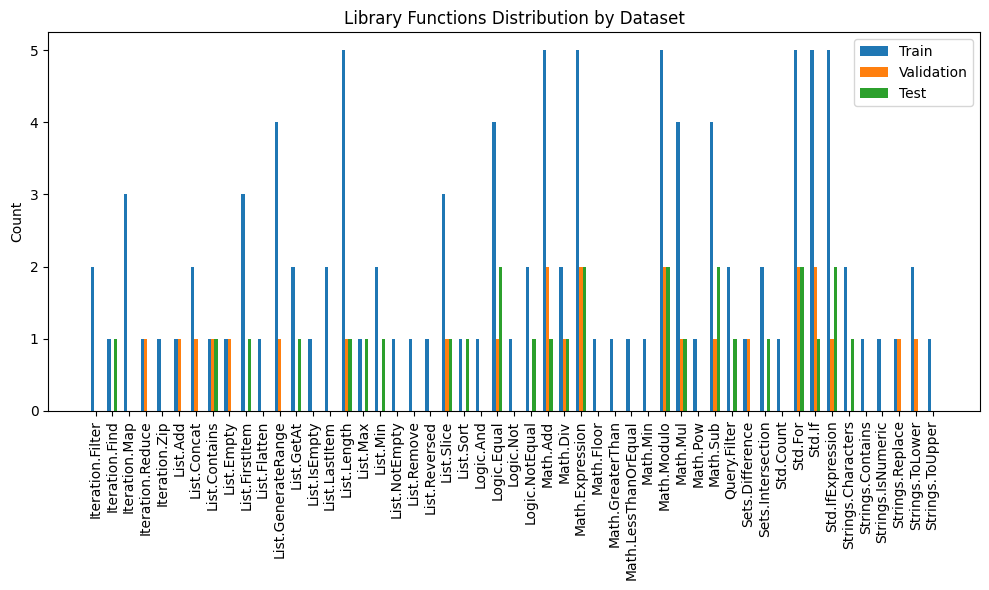

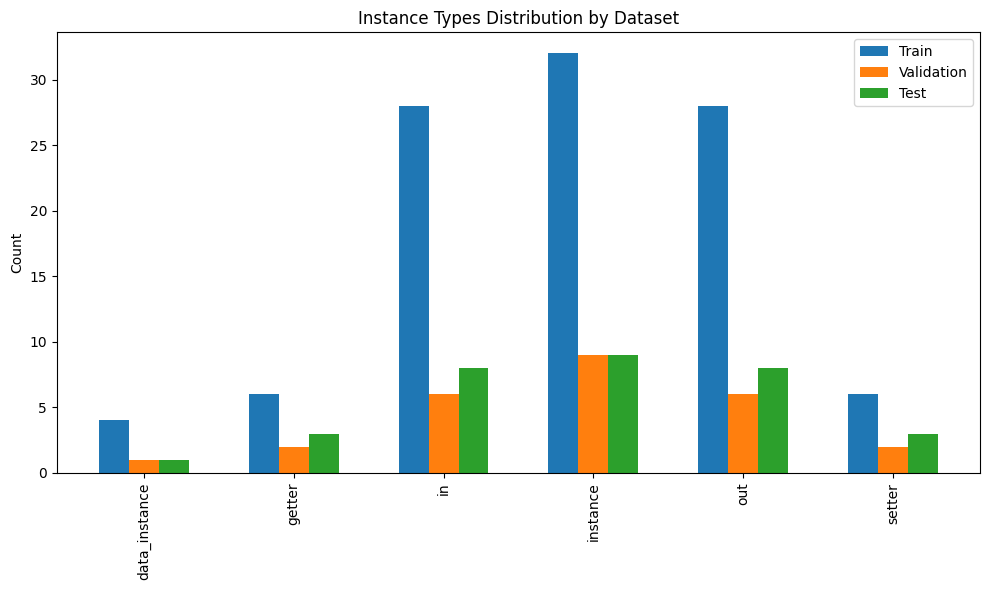

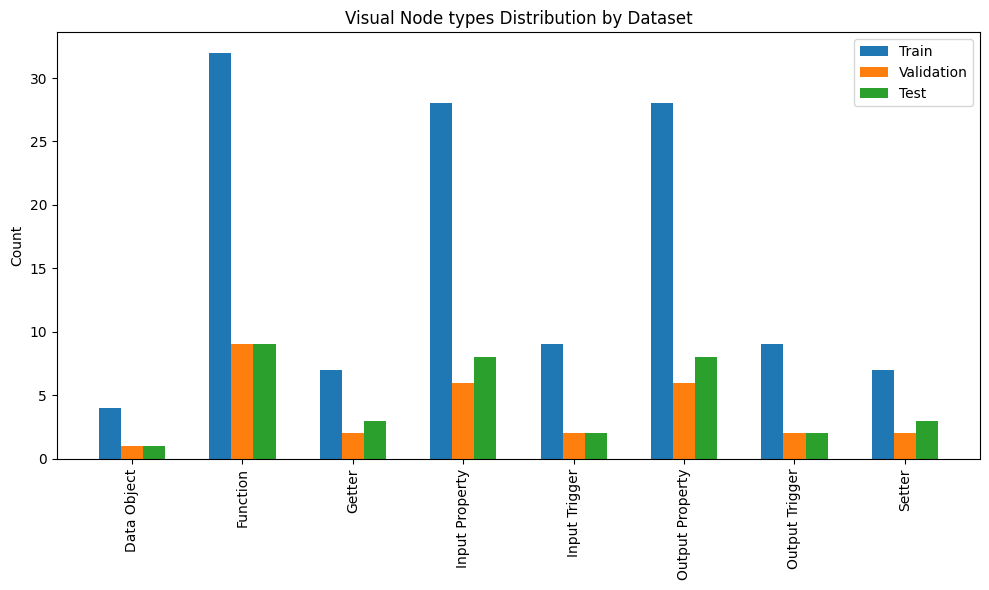

In [4]:
import json
import os
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
# Let's keep your 'prompts' as a separate array if needed
prompts = np.array([item['prompts'][0] for item in dataset], dtype=object)

# 'responses' is a list of lists of library functions
responses_raw = [item['library_functions'] for item in dataset]

# Build a list of all unique library functions
all_libs = sorted({fn for libs in responses_raw for fn in libs})
lib_to_idx = {fn: i for i, fn in enumerate(all_libs)}
num_labels = len(all_libs)

# Create a binary indicator matrix Y of shape [n_samples, num_labels]
Y = np.zeros((len(responses_raw), num_labels), dtype=int)
for i, libs in enumerate(responses_raw):
    for fn in libs:
        Y[i, lib_to_idx[fn]] = 1

# print("Number of possible labels (unique library functions):", num_labels)
# print("Y shape:", Y.shape)
# print("Example row of Y:", Y[0])
# print("Corresponding labels in that row:", 
#       [all_libs[idx] for idx in np.where(Y[0] == 1)[0]])

SEED = 58
# We want to do an 40% test split, preserving distribution of multi-labels
mskf = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=SEED)

# 'data' is your full dataset, 'Y' is the multi-label matrix
for train_index, test_index in mskf.split(data, Y):
    train = data[train_index]
    test  = data[test_index]
    
    Y_train = Y[train_index]
    Y_test  = Y[test_index]

print("Train shape:", train.shape)
print("Test  shape:", test.shape)
# Now we do a second split from the 'test' portion to get 'val' and final 'test'
# so each is half of that portion (20% / 20% of original data),
# but still preserving multi-label distribution.

mskf2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
for val_index, test_index_2 in mskf2.split(test, Y_test):
    val  = test[val_index]
    test = test[test_index_2]
    
    Y_val  = Y_test[val_index]
    Y_test = Y_test[test_index_2]

print("Final shapes:")
print("Train:", train.shape)
print("Validation:", val.shape)
print("Test:", test.shape)
def collect_libraries(data_subset):
    """
    Collects all library functions from the 'library_functions' key
    in a given subset of the dataset and returns them as a set.
    """
    libs = set()
    for item in data_subset:
        for fn in item['library_functions']:
            libs.add(fn)
    return libs

train_libs = collect_libraries(train)
val_libs   = collect_libraries(val)
test_libs  = collect_libraries(test)
print("Number of unique libraries in train:", len(train_libs))
print("Number of unique libraries in validation:", len(val_libs))
print("Number of unique libraries in test:", len(test_libs))

# Step 2: Identify library functions present in val or test but not in train.

val_extra_libs  = val_libs - train_libs
test_extra_libs = test_libs - train_libs

# Step 3: Print the results.

if val_extra_libs:
    print("Libraries in validation set not present in training set:")
    print(val_extra_libs)
else:
    print("No 'new' libraries in validation set that aren't in training.")

if test_extra_libs:
    print("Libraries in test set not present in training set:")
    print(test_extra_libs)
else:
    print("No 'new' libraries in test set that aren't in training.")

#Write to file:

full_path = os.path.join('../../data')

with open(f'{full_path}/train_dataset.json', 'w') as train_file:
    json.dump(train.tolist(), train_file, indent=4)

with open(f'{full_path}/validation_dataset.json', 'w') as eval_file:
    json.dump(val.tolist(), eval_file, indent=4)

with open(f'{full_path}/test_dataset.json', 'w') as test_file:
    json.dump(test.tolist(), test_file, indent=4)

# Analyze distribution across train / val / test
analyze_library_distribution(train, val, test)
analyze_instance_distribution(train, val, test)
analyze_visual_node_types_distribution(train, val, test)



## To correct data format

In [5]:

from my_packages.prompting.few_shot import transform_node_data

train_data = transform_node_data(train)
val_data = transform_node_data(val)
test_data = transform_node_data(test)

used_libraries_json = used_libraries_from_dataset(dataset)
available_nodes = used_libraries_to_string(used_libraries_json)

Library functions included in the dataset: 51


# Init model provider

In [6]:
import os
from dotenv import load_dotenv
from my_packages.utils.tokens_utils import models_not_in_file, write_models_nodes_tokens_to_file
from my_packages.utils.server_utils import server_diagnostics, is_remote_server_reachable
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

model_provider = 'ollama'

all_responses = [sample['response'] for sample in train_data] + [sample['response'] for sample in val_data] + [sample['response'] for sample in test_data]

match model_provider:
    case 'ollama':
        host = 'http://localhost:11434'
        if is_remote_server_reachable(url = host + "/api/tags"):
            print("Server is reachable.")
        else:
            server_diagnostics()
            print("Ollama server is not reachable. Batch job might have finished. Try running bash script again.")

        embed_client = OllamaEmbeddings
        client = ChatOllama
        models = [
            #14b models:
            "phi4:14b-fp16",
            # "qwen2.5:14b-instruct-fp16",
            #32b models:
            # "qwq:32b-preview-fp16",
            # "qwen2.5-coder:32b-instruct-fp16",
        #     # "deepseek-r1"
        #     #70b models:
            # "llama3.3:70b-instruct-fp16",
            # "qwen2.5:72b-instruct-fp16",
        ]
        # few_shot_messages = create_few_shot_messages(explained_used_libraries, train_prompts, train_responses, "NODE_GENERATOR_TEMPLATE", "system")
        models_not_tokenized = models_not_in_file(models, 'nodes_max_tokens.json')
        write_models_nodes_tokens_to_file(embed_client, models_not_tokenized, all_responses, 'nodes_max_tokens.json')

    case 'openai':
        load_dotenv("../../.env")
        openai_token = os.getenv('OPENAI_API_KEY')
        if not openai_token:
            raise Exception("OpenAI API key not found in .env file")
        client = ChatOpenAI
        embed_client = OpenAIEmbeddings
        models = [
            "gpt-4o",
            # "o1-preview", 
        ]
        # few_shot_messages = create_few_shot_messages(explained_used_libraries, train_prompts, train_responses, "NODE_GENERATOR_TEMPLATE", "developer")
        models_not_tokenized = models_not_in_file(models, 'nodes_max_tokens.json')
        write_models_nodes_tokens_to_file(client, models_not_tokenized, all_responses, 'nodes_max_tokens.json')

    case 'anthropic':
        load_dotenv("../../.env")
        anthropic_token = os.getenv('ANTHROPIC_API_KEY')
        if not anthropic_token:
            raise Exception("Anthropic API key not found in .env file")
        client = ChatAnthropic
        # embed_client = AnthropicEmbeddings
        models = [
            "claude-3-5-sonnet-latest"
        ]
        # few_shot_messages = create_few_shot_messages(explained_used_libraries, train_prompts, train_responses, "NODE_GENERATOR_TEMPLATE", "system")
        models_not_tokenized = models_not_in_file(models, 'nodes_max_tokens.json')
        write_models_nodes_tokens_to_file(client, models_not_tokenized, all_responses, 'nodes_max_tokens.json')
    case _:
        raise Exception("Model provider not supported")




Server is reachable.


## Experiemtn settings

In [7]:
from my_packages.prompting.few_shot import get_semantic_similarity_example_selector


prompt_prefix = "Create a flow" # "e.g., "Creat a function"

selector = get_semantic_similarity_example_selector(
        train_data, 
        embed_client(model=models[0]),
        shots=5,
    )

all_1 = set()

task =  val_data[1]["task"]
examples = selector.select_examples({"task": task})
print(examples)
print("> " + task)

for example in examples:
    print(example['task'])
    print(example['response'])
    print("\n")
    all_1.add(example['task'])

all_2 = set()

task =  val_data[1]["task"]
examples = selector.select_examples({"task": task})
print(examples)
print("> " + task)

for example in examples:
    print(example['task'])
    print(example['response'])
    print("\n")
    all_2.add(example['task'])

all_3 = set()

task =  val_data[1]["task"]
examples = selector.select_examples({"task": task})
print(examples)
print("> " + task)

for example in examples:
    print(example['task'])
    print(example['response'])
    print("\n")
    all_3.add(example['task'])
    
print(len(all_1.intersection(all_2.intersection(all_3))))

[{'response': 'Iteration.Map, List.GenerateRange, Math.LessThanOrEqual, Std.For, Logic.And, Std.If, Math.Expression, Math.Add, Math.Mul', 'task': 'Create a flow to check whether the given number is a perfect square or not.'}, {'response': 'Math.Pow, Iteration.Map', 'task': 'Create a flow to find cubes of individual elements in a list.'}, {'response': 'List.FirstItem, List.LastItem, List.Flatten, List.Slice, List.Length, Math.Sub', 'task': 'Create a flow to interchange the first and last element in a given list.'}, {'response': 'List.Length, Math.GreaterThan', 'task': 'Create a flow to check whether the entered number is greater than the elements of the given array.'}, {'response': 'Std.For, List.Concat, Std.IfExpression, List.Empty, List.Add, Query.Filter', 'task': 'Create a flow to move all zeroes to the end of the given list.'}]
> Create a flow to find whether a number is divisible by 11.
Create a flow to check whether the given number is a perfect square or not.
Iteration.Map, List.

# Evaluation

In [8]:
import json
import sys
import numpy as np
from my_packages.prompting.few_shot import get_random_example_selector, get_semantic_similarity_example_selector
sys.path.append('../')  # Add the path to the my_packages module
from my_packages.evaluation.node_evaluation import run_validation, run_testing, print_validation_result, print_test_result, calculate_deviation
from my_packages.utils.tokens_utils import get_model_code_tokens_from_file
from colorama import Fore, Back, Style
NUM_SHOTS = 5

random_selector = False

results = {}
for model_name in models:
    print(f"Model: {model_name}")
    model = get_model_code_tokens_from_file(model_name, 'nodes_max_tokens.json')
    #***************************Need to select few-shots examples for every task here. 
    # And send a dictionary of tasks to the run_validation and run_testing function
    # Check that all exmaples produced are unique! Not same task is selected multiple times.
    if random_selector:
        selector = get_random_example_selector(
            train_data, 
            embed_client(model=model_name),
            shots=NUM_SHOTS,
            seed=9
        )
    else:
        selector = get_semantic_similarity_example_selector(
            train_data, 
            embed_client(model=model_name),
            shots=NUM_SHOTS,
        )

    validation_result = None
    # validation_result = {
    #     "seed": None,
    #     "val_f1": 0.58,
    #     "val_pass_ks": {"pass@1": 0.2},
    #     "temperature": 0.6,
    #     "top_k": 10,
    #     "top_p": 0.9,
    # }

    if validation_result == None:
  
        validation_result = run_validation(
            client,
            model,
            available_nodes,
            val_data,
            selector,
            temperatures=[0.2, 0.6, 0.9],
            top_ps=[0.2, 0.6, 0.9],
            top_ks=[10, 50, 100],
            ks=[1],
            seed=9,
            debug=True,
        )
    print_validation_result(validation_result)

    test_results = run_testing(
        client,
        model,
        available_nodes,
        test_data,
        selector,
        temperature=validation_result["temperature"],
        top_p=validation_result["top_p"],
        top_k=validation_result["top_k"],
        ks=[1, 5], # k generations per task
        seeds=[3, 75, 346],
        debug=False,
    )
    results[model["name"]] = (validation_result, test_results)
      
# Print the final results
print("\nTesting and validation result:")
for model_name, (val_run, test_runs) in results.items():
    print(f"{Style.BRIGHT}{Fore.CYAN} Model: {model_name} {Style.RESET_ALL}")
    print_validation_result(val_run)
    for run in test_runs:
        print_test_result(run)
    

    mean_f1, f1_std, mean_pass_k, pass_ks_std = calculate_deviation(test_runs)
    print("\nFINAL RESULTS:")
    print(f"\n{Fore.GREEN}{Style.BRIGHT}")
    print(f"Test F1 mean: {mean_f1}\n")
    print(f"Test F1 std: {f1_std}\n")
    print(f"Test Pass@ks mean: {json.dumps(mean_pass_k, indent=4)}\n")
    print(f"Test Pass@ks std: {json.dumps(pass_ks_std, indent=4)}\n")
    f"{Style.RESET_ALL}"


Model: phi4:14b-fp16


Validation Phase:
Generating response for sample 0..

=== Sample: 0 ===
 User prompt: 
System: You are an expert node selector for the node-based language Midio. 
You will get prompted with a task and you will respond with the Nodes that might be used to solve the given task.

You must return the nodes in the following form, with a comma to seperate each node:

```midio

    //Node1, Node2, Node3 etc.

```

Bellow is the list of Nodes that you can choose from:
Function node name: Std.If
 Documentation: If `input` is true, the `then` trigger is executed, otherwise the `else` trigger is executed. `value` contains the value of `input`.

Function node name: Std.IfExpression
 Documentation: IfExpression is a function that allows you to create a conditional expression using a simple expression language provided through the `expression` parameter. Example: `a > b ? a : b` creates two inputs, `a` and `b`. The expression is executed using the provided inputs, and the result is available on the 

KeyboardInterrupt: 